SPLITTING TRIANGLE WAVE SCANS

Data info:
  Total duration: 40.000 s
  Cycle duration: 0.500 s
  Half cycle (forward/backward): 0.250 s
  Complete cycles detected: 79
  Total samples: 158 (79 forward + 79 backward)

⚠ Center extraction enabled:
  Extracting: 80.0% from center
  Discarding: 10.0% from each end
  Each scan duration: 0.250 s → 0.200 s

Extracted samples:
  Forward scans: 79
  Backward scans: 79
  Total: 158

Forward scan statistics:
  Average points per scan: 4001.0
  First scan duration: 0.200000 s
  First scan MI range: [0.0056, 0.9944]

Backward scan statistics:
  Average points per scan: 4001.0
  First scan duration: 0.200000 s
  First scan MI range: [0.0056, 0.9944]

Visualization saved: ./DATA/scan_splitting.png

Combined 158 samples (forward + backward)


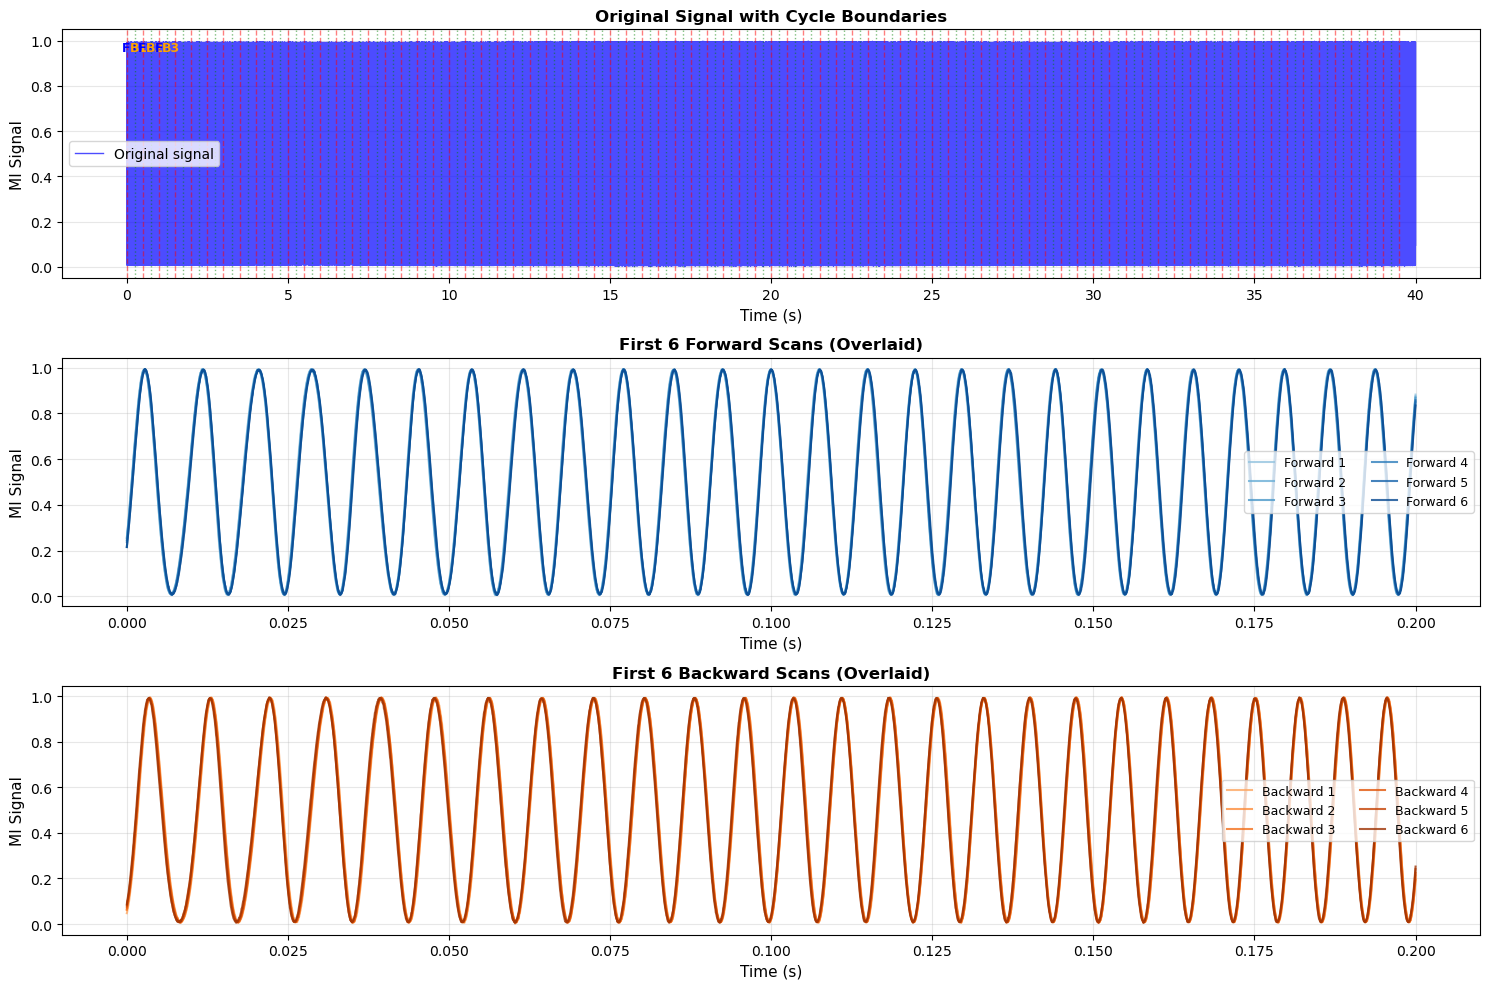

In [2]:
from sys import path
path.append('../')

from analysis2 import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

## data preparation
t, mi = load_data("../data/m400_.npy", 2, 0, 50) # filename, CH, start, end


t_start, t_end = 10, 50 # forward
# t_start, t_end = N + 0.2501, N + 0.5 # backward


mask = (t >= t_start) & (t <= t_end)
t_roi, mi_roi = t[mask], mi[mask]
t_roi = t_roi - t_roi[0]
mi_roi = (mi_roi - np.min(mi_roi)) / (np.max(mi_roi) - np.min(mi_roi))

from prepare_training_data import split_triangle_scans, combine_samples_for_training
from nonlinear_phase_fitter import NonlinearPhaseFitter

# 2. Split with center extraction
forward, backward = split_triangle_scans(
    t_roi, mi_roi,
    cycle_duration=0.5,
    center_fraction=0.8  # ← Extract central 80%
)

# 3. Combine samples
training_samples = combine_samples_for_training(forward, backward, use_both=True)


In [90]:
time_new, mi_new = load_data("../data/0_.npy", 2, 0, 50)
time_new, snom_new = load_data("../data/0_.npy", 0, 0, 50)
N = 10
t_start, t_end = N + 0.025, N + 0.225
mask = (time_new >= t_start) & (time_new <= t_end)
t_roi_new, mi_roi_new, snom_roi_new = time_new[mask], mi_new[mask], snom_new[mask]

In [93]:
np.max(snom_roi_new)*250e-9/1.1

7.687560613636363e-08

In [86]:
from improved_phase_fitter import simple_fit_mi_signal, plot_simple_fit_result, plot_edge_analysis, fit_with_adaptive_outlier_removal,_fit_single_iteration,plot_adaptive_removal_result
from scipy.signal import hilbert
import numpy as np
from Hilbert_snom_fit import fit_snom_ultimate, plot_ultimate_fit

# Your data
# Load new data and fit
time_new, mi_new = load_data("../data/0_.npy", 2, 0, 50)
time_new, snom_new = load_data("../data/0_.npy", 0, 0, 50)

beta = []

for N in np.arange(10,50, 0.5):
    t_start, t_end = N + 0.025, N + 0.225
    mask = (time_new >= t_start) & (time_new <= t_end)
    t_roi_new, mi_roi_new, snom_roi_new = time_new[mask], mi_new[mask], snom_new[mask]
    t_roi_new = t_roi_new - t_roi_new[0]
    mi_roi_new = (mi_roi_new - np.min(mi_roi_new)) / (np.max(mi_roi_new) - np.min(mi_roi_new))
    snom_roi_new = (snom_roi_new - np.min(snom_roi_new)) / (np.max(snom_roi_new) - np.min(snom_roi_new))

    # Your data
    fit_result = fit_with_adaptive_outlier_removal(
        t_roi_new, mi_roi_new, snom_roi_new,
        wavelength=1389e-9, # Discard 5% from EACH edge (10% total)
        verbose=True
    )

    Y = fit_result['fitted_signal']
    Z = fit_result['snom_signal']

    # 1) Remove DC offset
    Y_dc_removed = Y - np.mean(Y)

    # 2) Apply Hilbert transform
    Y_analytic = hilbert(Y_dc_removed)

    # 3)Instantaneous amplitude and phase
    amp = np.abs(Y_analytic)
    phase = np.angle(Y_analytic)

    # 4) Unwrap phase to get smooth phi(t)
    phase_unwrapped = np.unwrap(phase)

    # 5) Choose reference index for x-0
    phi0 = 0

    # 6) Phse -> position for interferometer
    wavelength = 1389e-9
    x_m = (wavelength / (4 * np.pi)) * (phase_unwrapped - phi0)
    X = x_m

    # Your data
    x = X
    snom_signal = Z


    # Fit
    fitted_signal, parameters, residuals, quality, components = fit_snom_ultimate(
        X, Z,
        trim_edges=0.1,
        verbose=True
    )

    beta.append(parameters['beta'])

# # Plot comparison
    # _fit_single_iteration(mi_roi_new, mi_roi_new, fit)
    # plot_adaptive_removal_result(fit_result)

# Plot
# plot_simple_fit_result(t_roi_new, mi_roi_new, fit_result)

# plot_edge_analysis(t_roi_new, mi_roi_new, fit_result)

# Results
# print(f"R²: {fit_result['r_squared']:.6f}")
# print(f"RMSE: {fit_result['rmse']:.6f}")
# fitted_signal = fit_result['fitted_signal']
# residuals = fit_result['residuals']


ADAPTIVE OUTLIER REMOVAL FITTING

Parameters:
  Outlier threshold: 3.0 × std dev
  Max iterations: 5
  Max removal: 15.0% of points

Original signal:
  Points: 4001
  Duration: 0.200000 s

ITERATION 1
  Current points: 4001 (100.0% of original)
  RMSE: 0.015792
  R²: 0.997969
  Residual std: 0.015792
  Outlier threshold: 0.047375
  Outliers found: 47
  Removed points at times:
    0.000000 to 0.003300 s (47 points)

ITERATION 2
  Current points: 3954 (98.8% of original)
  RMSE: 0.006069
  R²: 0.999701
  Residual std: 0.006069
  Outlier threshold: 0.018206
  Outliers found: 35
  Removed points at times:
    0.000150 to 0.199950 s (35 points)

ITERATION 3
  Current points: 3919 (98.0% of original)
  RMSE: 0.013588
  R²: 0.998495
  Residual std: 0.013588
  Outlier threshold: 0.040764
  Outliers found: 58
  Removed points at times:
    0.000200 to 0.199000 s (58 points)

ITERATION 4
  Current points: 3861 (96.5% of original)
  RMSE: 0.005506
  R²: 0.999754
  Residual std: 0.005503
  Outli

In [87]:
beta = np.asarray(beta)
pitch = np.pi/beta*1e6

def nearest_diameter_from_pitch(pitches_m, pitch_values_m, dia_vals):
    """
    For each measured pitch in meters, find j that minimizes |pitch_values_m[j] - pitches_m[i]|
    and return dia_vals[j]. Works for 1D arrays.
    """
    pitches_m = np.asarray(pitches_m, float).ravel()
    pv = pitch_values_m.ravel()
    dv = dia_vals.ravel()

    # broadcast differences: (len(pitches), len(pv))
    idx = np.abs(pitches_m[:, None] - pv[None, :]).argmin(axis=1)
    return dv[idx], idx

data = np.load('../pitches_and_diameters_1389.npz')
pitch_values = data['pitches_1389']
interpolated_dia_values = data['diameters_1389']

d_array, idx1 = nearest_diameter_from_pitch(pitch, pitch_values, interpolated_dia_values)

# d_array = d_array[d_array < 600e-9]




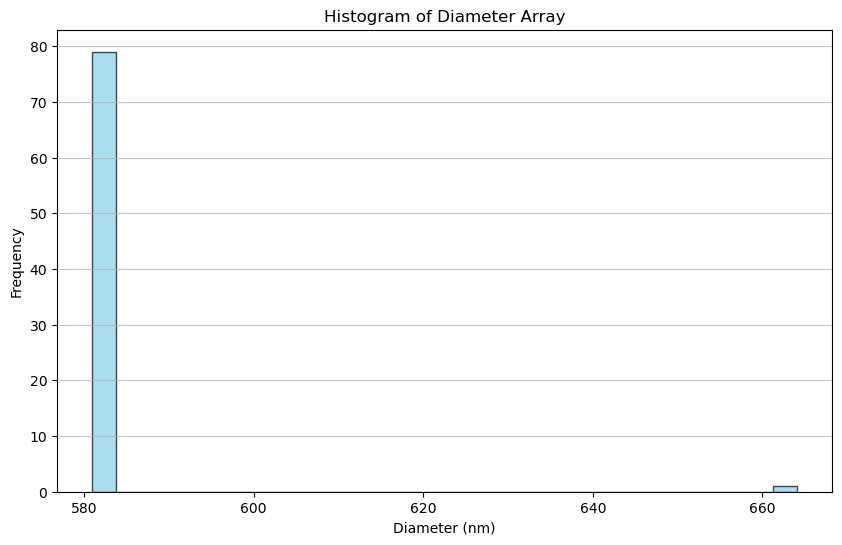

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(d_array*1e9, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Diameter (nm)')
plt.ylabel('Frequency')
plt.title('Histogram of Diameter Array')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [ ]:
T = fit_result['time']
Y = fit_result['fitted_signal']
Z = fit_result['snom_signal']

from scipy.signal import hilbert

# 1) Remove DC offset
Y_dc_removed = Y - np.mean(Y)

# 2) Apply Hilbert transform
Y_analytic = hilbert(Y_dc_removed)

# 3)Instantaneous amplitude and phase
amp = np.abs(Y_analytic)
phase = np.angle(Y_analytic)

# 4) Unwrap phase to get smooth phi(t)
phase_unwrapped = np.unwrap(phase)

# 5) Choose reference index for x-0
phi0 = 0

# 6) Phse -> position for interferometer
wavelength = 1389e-9
x_m = (wavelength / (4 * np.pi)) * (phase_unwrapped - phi0)
X = x_m

# Your data
x = X
snom_signal = Z

import numpy as np
from Hilbert_snom_fit import fit_snom_ultimate, plot_ultimate_fit

# Fit
fitted_signal, parameters, residuals, quality, components = fit_snom_ultimate(
    X, Z,
    trim_edges=0.1,
    verbose=True
)












Ultimate SNOM Fitter
Trimming 10% from each edge (374 points)

Step 1: Extracting envelope with Hilbert transform...
  Envelope range: 0.1354 to 0.7537

Step 2: Normalized signal
  Range: 0.0077 to 1.3797

Step 3: Fitting normalized signal with offset & amplitude trends...
  Initial beta: 5.7379e+06 rad/m
  Initial offset: 0.4533 + 3.6899e+04×x

Results:
  R² = 0.883253
  RMSE = 9.451166e-02
  Period = 0.5533 μm


In [58]:
import numpy as np
from better_snom_fit import fit_snom_full, plot_fit

# Your data
x = X
snom_signal = Z

# # Robust fit (recommended!)
# fitted, params, res, qual, env, norm = fit_snom_full(
#     x, snom_signal,
#     envelope_degree=2,
#     method='robust'  # ~1 minute, but reliable!
# )

# # Plot
# plot_fit(x, snom_signal, fitted, res, qual, params, env, norm,
#          save_path='my_fit.png')

# # Results
# print(f"R² = {qual['r_squared']:.4f}")
# if qual['r_squared'] > 0.95:
#     print("✓ Excellent fit!")

Ultimate SNOM Fitter
Trimming 10% from each edge (382 points)

Step 1: Extracting envelope with Hilbert transform...
  Envelope range: 0.2821 to 0.6487

Step 2: Normalized signal
  Range: 0.0013 to 1.5797

Step 3: Fitting normalized signal with offset & amplitude trends...
  Initial beta: 4.7182e+06 rad/m
  Initial offset: 0.8613 + -5.2701e+03×x

Results:
  R² = 0.996564
  RMSE = 1.723786e-02
  Period = 0.6689 μm
Saved: fit.png


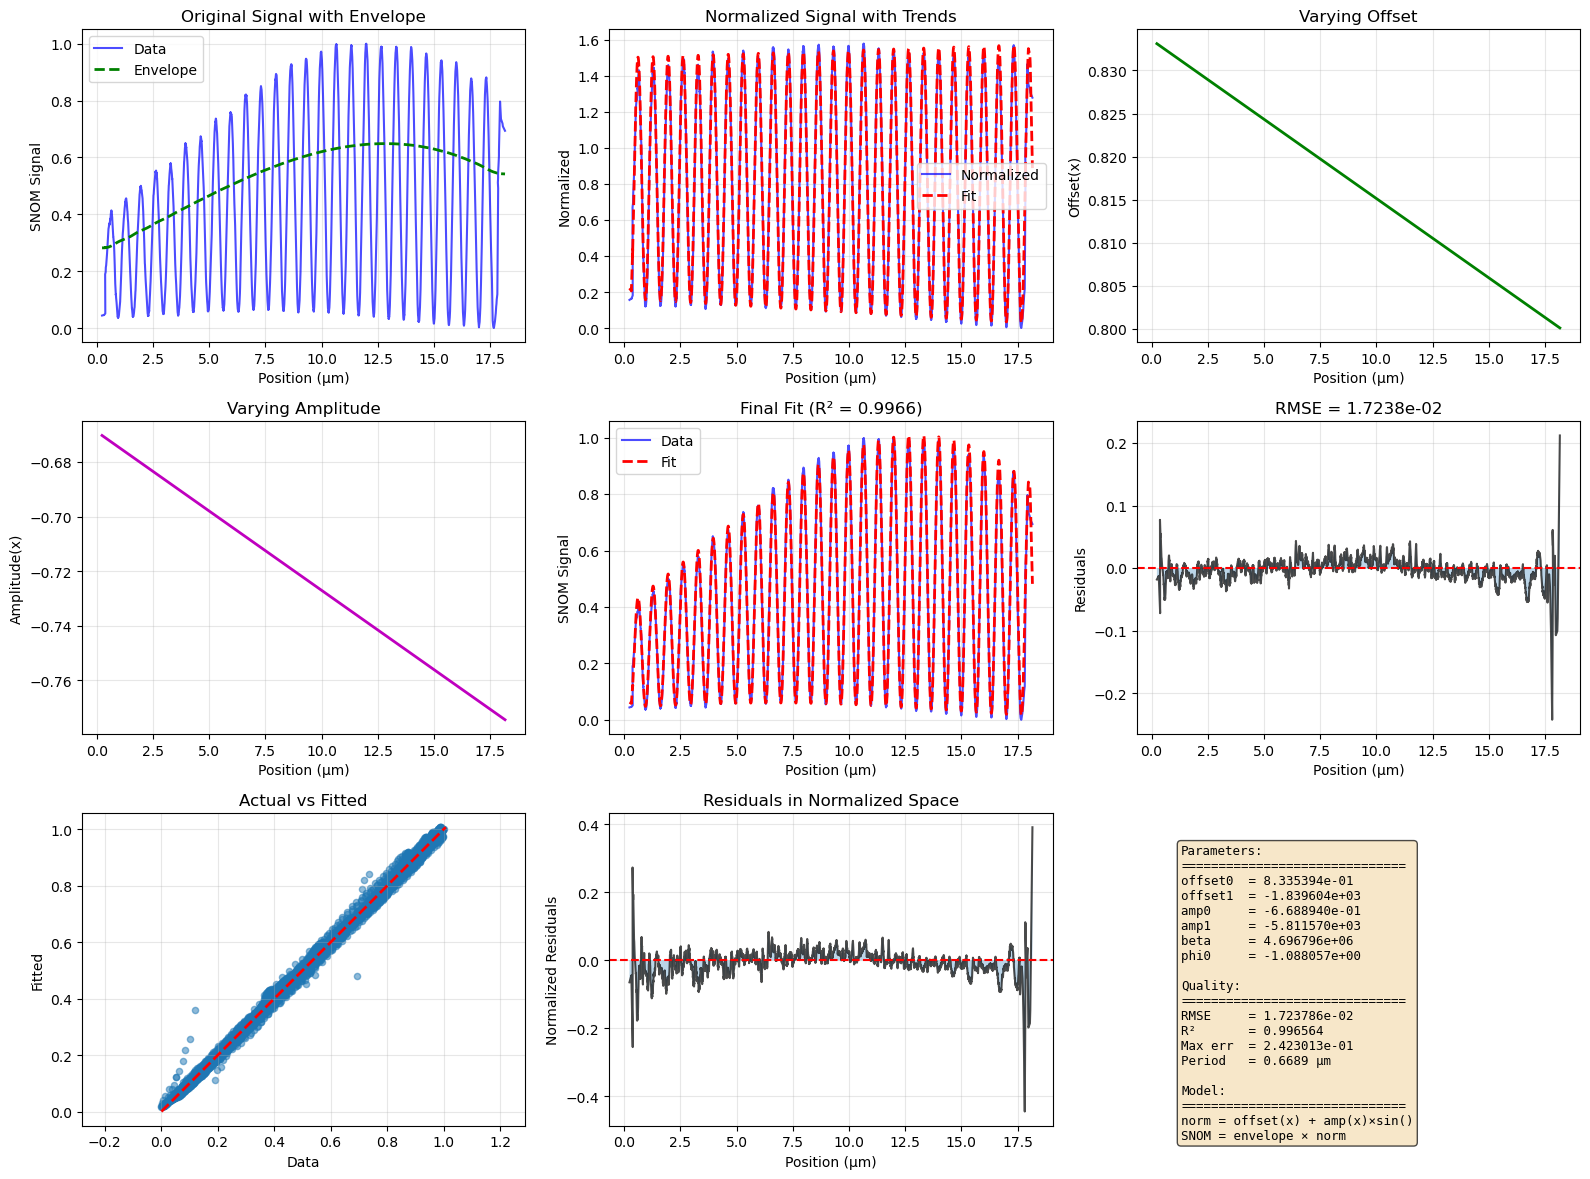

R² = 0.9966


In [59]:
import numpy as np
from Hilbert_snom_fit import fit_snom_ultimate, plot_ultimate_fit

# Fit
fitted_signal, parameters, residuals, quality, components = fit_snom_ultimate(
    X, Z,
    trim_edges=0.1,
    verbose=True
)

# Plot - CORRECT ORDER!
plot_ultimate_fit(
    X, Z,                # x, snom_signal
    fitted_signal,       # fitted
    residuals,           # residuals (NOT parameters!)
    quality,             # quality (NOT residuals!)
    parameters,          # parameters
    components,          # components
    save_path='fit.png'  # Use string, not 0
)

print(f"R² = {quality['r_squared']:.4f}")



In [28]:
np.pi/parameters['beta']

5.532608549907217e-07

Text(0, 0.5, 'Diameter (nm)')

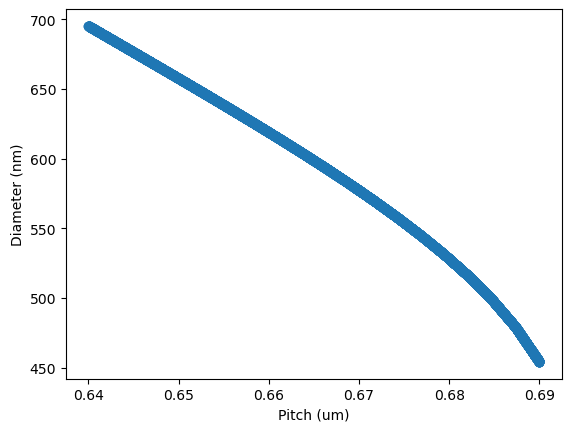

In [ ]:
data = np.load('../diameter_pitch_profile.npz')
pitch_values = data['pitch_values']
interpolated_dia_values = data['interpolated_dia_values']

plt.figure()
plt.plot(pitch_values, interpolated_dia_values*1e9, 'o', label='Pitch and Diameter')
plt.xlabel('Pitch (um)')
plt.ylabel('Diameter (nm)')

## Diameter converion 